In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 22.8 MB/s 
     |████████████████████████████████| 236 kB 77.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import pickle
from sklearn.cluster import DBSCAN
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__df = pd.read_csv(train_link)
    self.__pve_list = []
    self.__pca = 0
    self.__df_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0


  def one_hot_encoding(self,dataframe):
    keys = dataframe["key"].to_numpy()
    keys = np.array(['A', 'A#', 'B','C','C#','D', 'D#','E', 'F','F#' ,'G',  'G#'])
    modes = dataframe["mode"].to_numpy()
    modes = np.array(["Major", "Minor"])
    
    index_key = []
    for i in keys:
      index_key.append(np.where(np.array(dataframe["key"])==i))
    
    index_mode = []
    for i in modes:
      index_mode.append(np.where(np.array(dataframe["mode"])==i))


    lis2 = np.zeros((len(keys),len(dataframe)))
    for j in range(0,len(index_key)):
      for i in index_key[j]:
        lis2[j][i]=1
    #df_copy2=df.copy().reset_index()

    dataframe_new2= pd.DataFrame(lis2).T
    dataframe_new2.columns= keys
    dataframe= pd.concat([dataframe,dataframe_new2],axis=1)
    dataframe = dataframe.drop(columns = "key")
    
    lis3 = np.zeros((2,len(dataframe)))
    for j in range(0,len(index_mode)):
      for i in index_mode[j]:
        lis3[j][i]=1
    #df_copy3=df.copy().reset_index()

    dataframe_new3= pd.DataFrame(lis3).T
    dataframe_new3.columns= modes
    dataframe= pd.concat([dataframe,dataframe_new3],axis=1)
    dataframe = dataframe.drop(columns = ["mode"])
    return dataframe
  def preprocess_train_shape(self):
    df = self.__df
    df = df.drop(["artist_name","track_name","track_id","genre"],axis=1)
    df = self.one_hot_encoding(df)
    List1= [0,1,3,4,5]
    List2 = np.unique(df["time_signature"].to_numpy())
    Dic = dict(zip(List2, List1))
    df=df.replace({"time_signature": Dic})
    self.__scaler = MaxAbsScaler()
    df[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.fit_transform(df[["popularity","duration_ms","tempo","loudness","time_signature"]])
    self.__df = df
    self.__df_processed = df
    
  def get_processed_df(self):
    return self.__df_processed

  def get_PCA_plot(self):
    df = self.__df_processed
    arr = df.to_numpy()
    self.__number_of_components = [x for x in range(1,26)]
    

    for component in self.__number_of_components:
      pca = PCA(n_components=component)
      pca.fit(arr)
      self.__pve_list.append(np.sum(pca.explained_variance_ratio_))

    return self.__number_of_components, self.__pve_list



  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self):
    self.preprocess_train_shape()   
    #Apply PCA with 0.9 PVE
    arr = self.__df.to_numpy()
    self.__pca = PCA(0.9)
    self.__pca.fit(arr)
    transformed_arr = self.__pca.transform(arr)
    transformed_df = pd.DataFrame(data=transformed_arr,columns=[f"principal_componenet {x+1}" for x in range(transformed_arr.shape[1])])
    return transformed_df
  
  def preprocess_test(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test
  
  def call_playlist(self,link):
    #Authentication - without user
    client_credentials_manager = SpotifyClientCredentials(client_id="", client_secret="")
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

    playlist_link = link
    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    keys = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]
    dictionary = {}
    for i in sp.audio_features(track_uris):
      for key in i:
        if key not in dictionary:
          dictionary[key] = []
        dictionary[key].append(i[key])
    df = pd.DataFrame.from_dict(dictionary)
    popularity=[]
    for track in sp.playlist_tracks(playlist_URI)["items"]:
        popularity.append(track["track"]["popularity"])

    df_pop = pd.DataFrame(popularity)
    df_pop.columns=["popularity"]
    df=pd.concat([df_pop,df],axis=1)
    df = df.drop(["type","id","uri","track_href","analysis_url"],axis = 1)  

    test = df.to_csv("test.csv") 
    return df

  def preprocess_test_link(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test

  def preprocess_test_AE(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    test = test.mean()
    return test

  def preprocess_test_link_AE(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    test = test.mean()
    return test

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:
df_without_pca=Preprocessing("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:

df = df_without_pca.preprocess_train_shape()

In [ ]:
df = df_without_pca.get_processed_df()

In [ ]:
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C#,D,D#,E,F,F#,G,G#,Major,Minor
0,0.00,0.611,0.389,0.017896,0.910,0.000,0.3460,-0.034848,0.0525,0.687390,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.01,0.246,0.590,0.024739,0.737,0.000,0.1510,-0.105973,0.0868,0.716348,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.03,0.952,0.663,0.030663,0.131,0.000,0.1030,-0.264579,0.0362,0.409579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.00,0.703,0.240,0.027450,0.326,0.000,0.0985,-0.232152,0.0395,0.707105,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.04,0.950,0.331,0.014880,0.225,0.123,0.2020,-0.403187,0.0456,0.578733,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_original.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


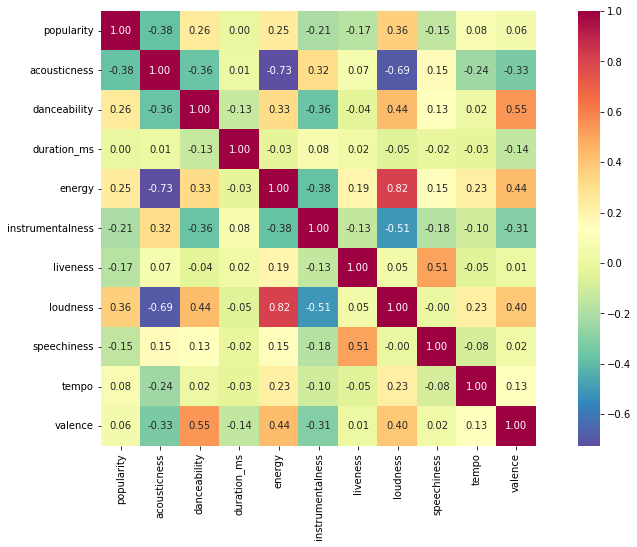

In [ ]:
plt.figure(figsize=(15,8))
corrmat = df_original.drop(columns=["artist_name","track_name","track_id","genre"]).corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size":10},cmap ="Spectral_r")
plt.show()

In [ ]:
test_1 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_test_pl_1.csv")
test_2 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_test_pl_2.csv")
test_3 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_pl3.csv")
test_4 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_sanat_muzigi.csv")
test_5 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_ucuncu_yeniler.csv")
test_6 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_metal.csv")
test_7 = df_without_pca.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_dylan.csv")
test_7

<ipython-input-5-a3aee0e482b7>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-a3aee0e482b7>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
<ipython-input-5-a3aee0e482b7>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-a3aee0e482b7>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
<ipython-input-5-a3aee0e482b7>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but i

popularity          0.450328
danceability        0.526902
energy              0.400423
loudness           -0.255227
speechiness         0.050856
acousticness        0.578262
instrumentalness    0.009645
liveness            0.160203
valence             0.497984
tempo               0.504722
duration_ms         0.054418
time_signature      0.767213
A                   0.000000
A#                  0.000000
B                   0.000000
C                   0.000000
C#                  0.000000
D                   0.000000
D#                  0.000000
E                   0.000000
F                   0.000000
F#                  0.000000
G                   0.000000
G#                  0.000000
Major               0.000000
Minor               0.000000
dtype: float64

In [ ]:
df_original.iloc[232112]

genre                                 Soul
artist_name                          Dwele
track_name                    I'm Cheatin'
track_id            2PKiB1i2DwG2npY2xxjLnE
popularity                              40
acousticness                         0.708
danceability                         0.746
duration_ms                         222800
energy                               0.457
instrumentalness                  0.000004
key                                     D#
liveness                             0.202
loudness                            -7.532
mode                                 Minor
speechiness                          0.049
tempo                               92.025
time_signature                         4/4
valence                              0.467
Name: 232112, dtype: object

<BarContainer object of 12 artists>

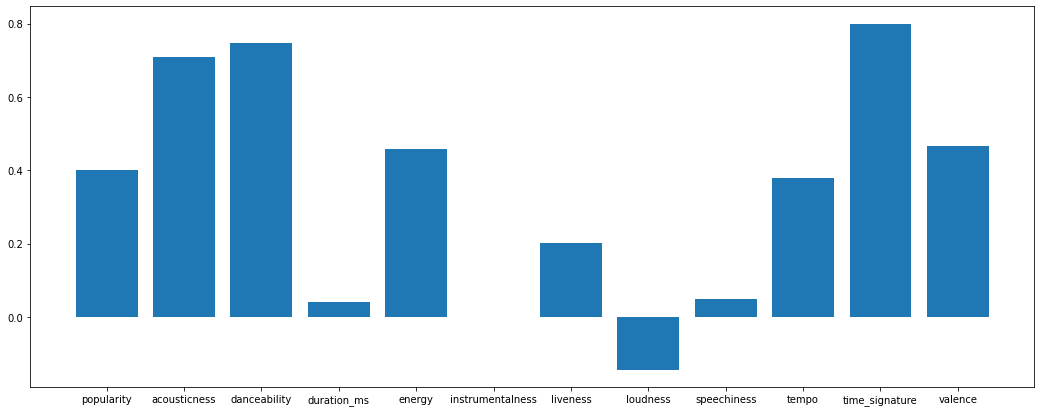

In [ ]:
labels = df.iloc[232112].T.index[:12]
values = df.iloc[232112].T.values[:12]

fig, axs = plt.subplots(1, 1, figsize=(18, 7), sharey=True)
axs.bar(labels, values)

In [ ]:
test_1.T.index[:12]


Index(['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

<BarContainer object of 12 artists>

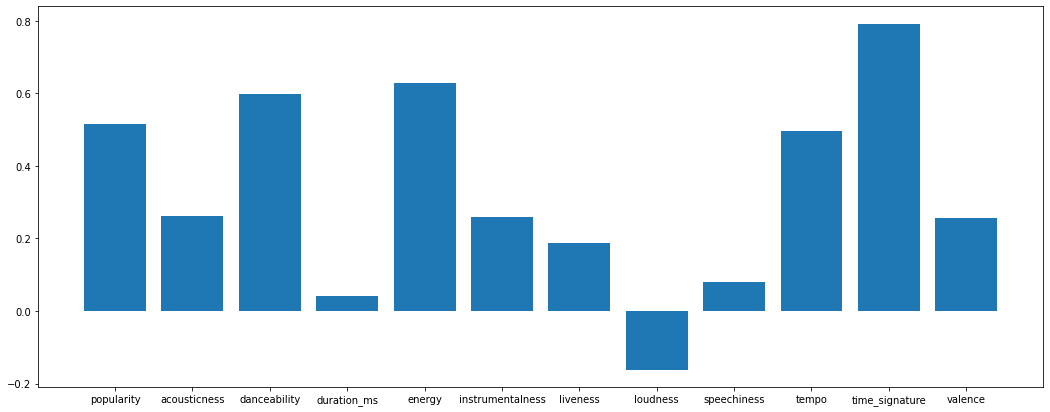

In [ ]:
test_1_cols = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness', 'speechiness','tempo','time_signature','valence']
test_1 = test_1[test_1_cols]
labels = test_1.T.index[:12]
values = test_1.T.values[:12]

fig, axs = plt.subplots(1, 1, figsize=(18, 7), sharey=True)
axs.bar(labels, values)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print('Mean squared error of recomended song and test_1 playlist:', mean_squared_error(test_1.T.values[:12],df.iloc[232112].T.values[:12]))
print('R2 score of recomended song and test_1 playlist:', r2_score(df.iloc[232112].T.values[:12],test_1.T.values[:12]))

Mean squared error of recomended song and test_1 playlist: 0.03238653063179512
R2 score of recomended song and test_1 playlist: 0.6433988618926254


In [ ]:
type(test_7)

pandas.core.series.Series

In [ ]:
test_6

popularity          0.415333
danceability        0.382333
energy              0.938467
loudness           -0.108082
speechiness         0.151367
acousticness        0.003617
instrumentalness    0.229110
liveness            0.126547
valence             0.313787
tempo               0.484348
duration_ms         0.062399
time_signature      0.800000
A                   0.000000
A#                  0.000000
B                   0.000000
C                   0.000000
C#                  0.000000
D                   0.000000
D#                  0.000000
E                   0.000000
F                   0.000000
F#                  0.000000
G                   0.000000
G#                  0.000000
Major               0.000000
Minor               0.000000
dtype: float64

#**k-Means**

In [ ]:
from kneed.knee_locator import KneeLocator

In [ ]:
number_of_clusters = [n for n in range(50,1050,50)]
inertias = []
silhouttes = []

for n in number_of_clusters:
  model = KMeans(n_clusters=n).fit(df)
  labels = model.labels_
  inertias.append(model.inertia_)
  score = silhouette_score(df,labels,metric="euclidean")
  print(f"Silhouette score for {n} clusters is {score}")
  silhouttes.append(score)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_score_wfe.pickle', 'wb') as f:
    pickle.dump(silhouttes, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia_wfe.pickle', 'wb') as f:
    pickle.dump(inertias, f, protocol=pickle.HIGHEST_PROTOCOL)

Silhouette score for 50 clusters is 0.3279513258309326
Silhouette score for 100 clusters is 0.2462100949367284
Silhouette score for 150 clusters is 0.22480279685112428
Silhouette score for 200 clusters is 0.1982532343041193
Silhouette score for 250 clusters is 0.18469332139714903
Silhouette score for 300 clusters is 0.17477434674226686
Silhouette score for 350 clusters is 0.16316495594139552
Silhouette score for 400 clusters is 0.15634514669204017
Silhouette score for 450 clusters is 0.1493613754067857
Silhouette score for 500 clusters is 0.1437710297044767
Silhouette score for 550 clusters is 0.13709115322305987
Silhouette score for 600 clusters is 0.13270769742112556
Silhouette score for 650 clusters is 0.13311836084126694
Silhouette score for 700 clusters is 0.13094056151382785
Silhouette score for 750 clusters is 0.12780808165771693
Silhouette score for 800 clusters is 0.12500556623643688
Silhouette score for 850 clusters is 0.12336399826832435
Silhouette score for 900 clusters is 

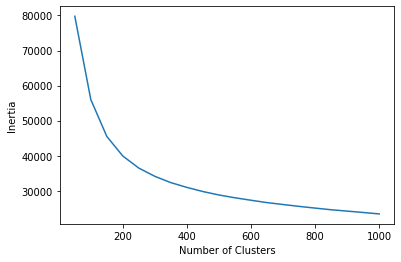

In [ ]:
plt.plot(number_of_clusters, inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia_wfe.pickle', 'rb') as f:
    inertias=pickle.load(f)

knee_locator = KneeLocator(range(50,1050,50),inertias,curve="convex", direction="decreasing")
print(f"Elbow for the inertia graph is {knee_locator.elbow}")

Elbow for the inertia graph is 250


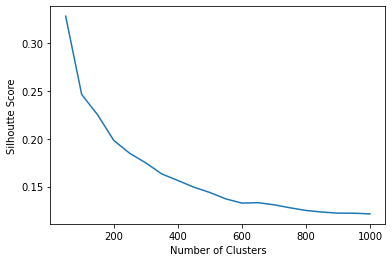

In [ ]:
plt.plot(number_of_clusters, silhouttes)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.show()

In [ ]:
model = KMeans(n_clusters=1000).fit(df.to_numpy())

In [ ]:
print(np.unique(model.labels_,return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [ ]:
print(model.predict([test_1.to_numpy()]))
print(model.predict([test_2.to_numpy()]))
print(model.predict([test_3.to_numpy()]))
print(model.predict([test_4.to_numpy()]))
print(model.predict([test_5.to_numpy()]))
print(model.predict([test_6.to_numpy()]))
print(model.predict([test_7.to_numpy()]))

[929]
[929]
[421]
[426]
[929]
[343]
[929]


In [ ]:
df_with_clusters = df_original.copy()
df_with_clusters["cluster"] = model.labels_

In [ ]:
df_with_clusters[df_with_clusters["artist_name"] == "Metallica"][["artist_name","track_name","cluster"]]

,artist_name,track_name,cluster
153065,Metallica,Moth Into Flame,140
153069,Metallica,Holier Than Thou,542
153210,Metallica,The Four Horsemen (Remastered),844
153245,Metallica,The Thing That Should Not Be (Remastered),894
153696,Metallica,Fight Fire With Fire (Remastered),792
153797,Metallica,Until It Sleeps,876
153836,Metallica,"Atlas, Rise!",344
153842,Metallica,Of Wolf And Man,763
153862,Metallica,Orion (Remastered),271
153963,Metallica,The Memory Remains,58


In [ ]:
def recommend_song(playlist,model,df_with_clusters):
  playlist_cluster = model.predict(playlist)[0]
  df_filtered = df_with_clusters[df_with_clusters["cluster"] == playlist_cluster]
  song_rec = df_filtered.sample(10)
  return song_rec[["artist_name","track_name"]]

In [ ]:
recommend_song([test_1.to_numpy()],model,df_with_clusters)

,artist_name,track_name
54470,Chorus,Vishambhari Stuti
58593,Katherine Jenkins,Amazing Grace
102496,Radiohead,Desert Island Disk
73695,Kimbo Children's Music,Whirling Strawberries (Bright 3/4 Meter)
11467,Saba,FIGHTER
125225,Granville Bantock,Violin Sonata No.3 in C major
10711,Grizfolk,Interlude
231153,Kelela,Bluff
66342,Amigo the Devil,The Dreamer
230930,James Morrison,Just Like A Child


In [ ]:
ind = np.argwhere(np.array(df_original.track_name)=="Vishambhari Stuti")
labels = df.iloc[ind[0][0]].T.index
values = df.iloc[ind[0][0]].T.values

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print('Mean squared error of recomended song and test_1 playlist:', mean_squared_error(test_1.T.values,values))
print('R2 score of recomended song and test_1 playlist:', r2_score(values,test_1.T.values))

Mean squared error of recomended song and test_1 playlist: 0.10762547161809757
R2 score of recomended song and test_1 playlist: -0.01328024830237684


In [ ]:
recommend_song(test_3.to_numpy(),model,df_with_clusters)

,artist_name,track_name
179652,DJ Harrison,On Time/ Backwoods
73303,Preschool Kids,For He's a Jolly Good Fellow
72281,Tom's Music Box,"Goldberg Variations No. 4, BWV 988"
74311,Kimbo Children's Music,It's a Wonderful Way 4/4
130550,Muzio Clementi,"Keyboard Sonatina In C Major, Op. 36, No. 3: I..."
45366,Bruce Faulconer,Earth Music
34236,Nobuo Uematsu,"Gold Saucer: Piano Collections Version (From ""..."
125659,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Variation 12 Can..."
126203,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Variation 18 a 1..."
76556,Heiter Pereira,The Friendship Song


In [ ]:
recommend_song(test_4.to_numpy(),model,df_with_clusters)

,artist_name,track_name
228612,Louis Futon,Supposed to Be
32309,Hello Sleepwalkers,Getsumen Hokou
232255,Janelle Monáe,Neon Gumbo
118747,Meek Mill,Traumatized
228228,Louis Futon,Supposed To Be
132413,Chee,Allergic To Public Displays Of Affection
88396,Meek Mill,Traumatized
68820,"quickly, quickly",Swingtheory
10197,Black Flag,My War
141933,Shoffy,Different Skies


In [ ]:
recommend_song(test_6.to_numpy(),model,df_with_clusters)

,artist_name,track_name
170406,Tommy Johnagin,Alpha Male
169853,Matt Braunger,Follow the Gorilla
174306,Josh Sneed,Getting Older vs Growing Up
88519,J. Cole,Kerney Sermon (Skit)
72696,Ibrary's Children's Music & Stories,Travelers and the Bear
205513,Kensuke Ushio,int
117025,KYLE,Ups & Downs
75590,Juice Music,Alice In Wonderland
173561,Todd Barry,Stomach Flu
70289,KYLE,Ups & Downs


# **DBSCAN**

If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=52) #26*2=52
nbrs = neigh.fit(df)
distances, indices = nbrs.kneighbors(df)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]


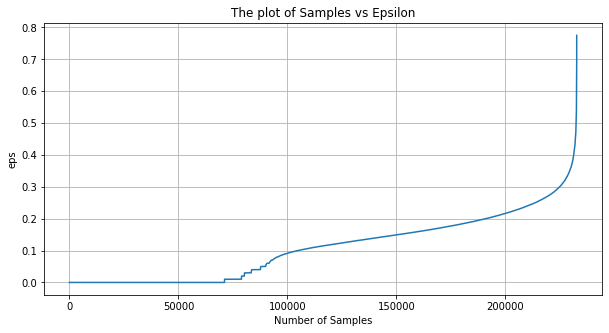

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title("The plot of Samples vs Epsilon")
plt.xlabel("Number of Samples")
plt.ylabel("eps")

plt.grid()

In [ ]:
#parameter tuning for eps varying from 0.2 to 0.49

score_list=[]
whole_turns = []
for eps in np.arange(0.20,0.62,0.02):
  clustering = DBSCAN(eps=eps, min_samples=52).fit(df)
  labels = clustering.labels_
  score = silhouette_score(df, labels)
  score_list.append(score)
  whole_turns.append([eps,52]) 
  print(f"Silhouette score for {eps} eps is {score}")

with open('/content/drive/MyDrive/CS464/Kod/dbscan_score.pickle', 'wb') as f:
    pickle.dump(silhouttes, f, protocol=pickle.HIGHEST_PROTOCOL)

max_score_index = score_list.index(max(score_list))
choice = whole_turns[max_score_index]
print('Best parameteres:','epsilon:',choice[0],'min_samples:',choice[1],'Silhoutte Score:',score_list[max_score_index])         

Silhouette score for 0.2 eps is -0.365021175654327
Silhouette score for 0.22 eps is -0.1486742594724377
Silhouette score for 0.24 eps is -0.049404677666662296
Silhouette score for 0.26 eps is 0.08264328456199142
Silhouette score for 0.27999999999999997 eps is 0.15835122348284897
Silhouette score for 0.29999999999999993 eps is 0.1850538459794227
Silhouette score for 0.31999999999999995 eps is 0.2299145411137273
Silhouette score for 0.33999999999999997 eps is 0.24483506789830106
Silhouette score for 0.35999999999999993 eps is 0.30205672160381025
Silhouette score for 0.3799999999999999 eps is 0.3110880515221055
Silhouette score for 0.3999999999999999 eps is 0.3266900047794215
Silhouette score for 0.41999999999999993 eps is 0.33517149183538875
Silhouette score for 0.4399999999999999 eps is 0.3403309459929633
Silhouette score for 0.4599999999999999 eps is 0.3488671577518499
Silhouette score for 0.47999999999999987 eps is 0.37389203691197226
Silhouette score for 0.49999999999999983 eps is 0.

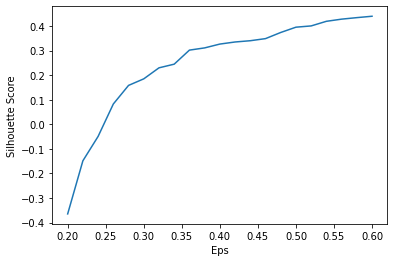

In [ ]:
plt.plot(np.arange(0.20,0.62,0.02),score_list)
plt.xlabel("Eps")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
dbscan_nopca = DBSCAN(eps=0.7, min_samples=52).fit(df)

In [ ]:
silhouette_score(df, dbscan_nopca.labels_)

0.4432927857125493

In [ ]:
np.unique(dbscan_nopca.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23]),
 array([   18, 16245,  7124,  5638, 11758,  8097, 21943, 20028,  8722,
         5105, 11329, 18466,  8665,  7442,  6361,  8795,  8084, 13874,
         8140,  9518,  8521,  5610,  6955,  3829,  2458]))

In [ ]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[:,i]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [ ]:
y_pred_1 = (dbscan_predict(dbscan_nopca,test_1.to_numpy().reshape(1,-1)))
y_pred_2 = (dbscan_predict(dbscan_nopca,test_2.to_numpy().reshape(1,-1)))
y_pred_3 = (dbscan_predict(dbscan_nopca,test_3.to_numpy().reshape(1,-1)))
y_pred_4 = (dbscan_predict(dbscan_nopca,test_4.to_numpy().reshape(1,-1)))
y_pred_5 = (dbscan_predict(dbscan_nopca,test_5.to_numpy().reshape(1,-1)))
y_pred_6 = (dbscan_predict(dbscan_nopca,test_6.to_numpy().reshape(1,-1)))
y_pred_7 =(dbscan_predict(dbscan_nopca,test_7.to_numpy().reshape(1,-1)))

In [ ]:
print(y_pred_1)
print(y_pred_2)
print(y_pred_3)
print(y_pred_4)
print(y_pred_5)
print(y_pred_6)
print(y_pred_7)




[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]


In [ ]:
 #take 10 recommendations from the desired cluster
def cluster_items(model, pred):
  cluster_num=pred[0]

  if cluster_num==-1:
      cluster_count = np.unique(model.labels_, return_counts=True)[1][0]
      song_rec=[]
      indexes = pd.DataFrame(np.argwhere(model.labels_==cluster_num))
      for i in range(0,len(indexes)):
        index = np.argwhere(model.labels_==cluster_num)[i][0]
        song_rec.append(np.array((df_original.iloc[index:index+1,1:3])))
      song_rec =pd.DataFrame(np.array(song_rec).reshape(cluster_count,2),columns=["artist_name","track name"])
      last_recomend = song_rec.sample(n=10)
  else:
    cluster_count = np.unique(model.labels_, return_counts=True)[1][pred[0]]
    song_rec=[]
    indexes = pd.DataFrame(np.argwhere(model.labels_==cluster_num))
    for i in range(0,len(indexes)):
      index = np.argwhere(model.labels_==cluster_num)[i][0]
      song_rec.append(np.array((df_original.iloc[index:index+1,1:3])))
    song_rec =pd.DataFrame(np.array(song_rec).reshape(cluster_count,2),columns=["artist_name","track name"])
    last_recomend = song_rec.sample(n=10)

  return last_recomend

In [ ]:
song_rec_1 =cluster_items(dbscan_nopca,y_pred_1)
song_rec_2 =cluster_items(dbscan_nopca,y_pred_2)
song_rec_3 =cluster_items(dbscan_nopca,y_pred_3)
song_rec_4 =cluster_items(dbscan_nopca,y_pred_4)
song_rec_5 =cluster_items(dbscan_nopca,y_pred_5)
song_rec_6 =cluster_items(dbscan_nopca,y_pred_6)
song_rec_7 =cluster_items(dbscan_nopca,y_pred_7)



In [ ]:
song_rec_1

,artist_name,track name
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
8,Franco Escamilla,Series De La Infancia
13,La Mesa Reñoña,"Episodio 14 (Machismo, Juanga, Bebé a Bordo)"
14,La Mesa Reñoña,"Episodio 15 (Lady Orinoco, Políticas De Youtub..."
3,Pepper,Ufa Point Skit
17,Jon Hopkins,Late Night Tales: Jon Hopkins - Continuous Mix
5,Keem the Cipher,Alpha.
15,Jamie Llewellyn,Nature Sounds for Sleep: Crackling Log Fire wi...
10,Pepper,Ufa Point Skit
1,Bonobo,Late Night Tales: Bonobo


<BarContainer object of 12 artists>

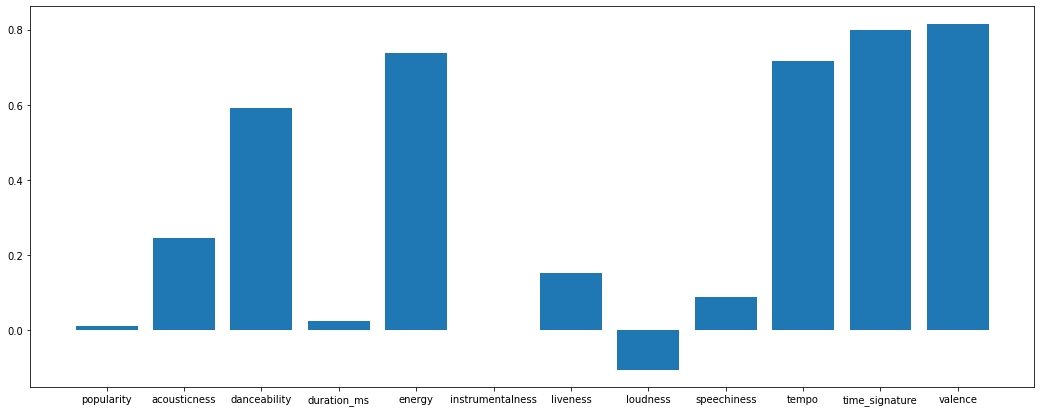

In [ ]:
labels = df.iloc[1].T.index[:12]
values = df.iloc[1].T.values[:12]

fig, axs = plt.subplots(1, 1, figsize=(18, 7), sharey=True)
axs.bar(labels, values)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print('Mean squared error of recomended song and test_1 playlist:', mean_squared_error(test_1.T.values[:12],df.iloc[1].T.values[:12]))
print('R2 score of recomended song and test_1 playlist:', r2_score(df.iloc[1].T.values[:12],test_1.T.values[:12]))

Mean squared error of recomended song and test_1 playlist: 0.0583795215643797
R2 score of recomended song and test_1 playlist: 0.5105692426491637


In [ ]:
song_rec_2

,artist_name,track name
6,Franco Escamilla,Lo Que No Le Dirías a Tu Pareja
2,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
7,Franco Escamilla,Apodos
9,Bonobo,Late Night Tales: Bonobo
17,Jon Hopkins,Late Night Tales: Jon Hopkins - Continuous Mix
16,Steve Reich,Music for 18 Musicians
1,Bonobo,Late Night Tales: Bonobo
3,Pepper,Ufa Point Skit
4,Bob Marley & The Wailers,Talkin'
13,La Mesa Reñoña,"Episodio 14 (Machismo, Juanga, Bebé a Bordo)"


In [ ]:
song_rec_3

,artist_name,track name
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
15,Jamie Llewellyn,Nature Sounds for Sleep: Crackling Log Fire wi...
8,Franco Escamilla,Series De La Infancia
4,Bob Marley & The Wailers,Talkin'
6,Franco Escamilla,Lo Que No Le Dirías a Tu Pareja
10,Pepper,Ufa Point Skit
13,La Mesa Reñoña,"Episodio 14 (Machismo, Juanga, Bebé a Bordo)"
5,Keem the Cipher,Alpha.
7,Franco Escamilla,Apodos
9,Bonobo,Late Night Tales: Bonobo


In [ ]:
song_rec_4

,artist_name,track name
15,Jamie Llewellyn,Nature Sounds for Sleep: Crackling Log Fire wi...
8,Franco Escamilla,Series De La Infancia
0,Chorus,Pedda Gedda
4,Bob Marley & The Wailers,Talkin'
12,Sade,Jezebel - Live 2011
16,Steve Reich,Music for 18 Musicians
6,Franco Escamilla,Lo Que No Le Dirías a Tu Pareja
9,Bonobo,Late Night Tales: Bonobo
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
14,La Mesa Reñoña,"Episodio 15 (Lady Orinoco, Políticas De Youtub..."


In [ ]:
song_rec_5

,artist_name,track name
4,Bob Marley & The Wailers,Talkin'
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
2,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
14,La Mesa Reñoña,"Episodio 15 (Lady Orinoco, Políticas De Youtub..."
8,Franco Escamilla,Series De La Infancia
6,Franco Escamilla,Lo Que No Le Dirías a Tu Pareja
10,Pepper,Ufa Point Skit
0,Chorus,Pedda Gedda
17,Jon Hopkins,Late Night Tales: Jon Hopkins - Continuous Mix
16,Steve Reich,Music for 18 Musicians


In [ ]:
song_rec_6

,artist_name,track name
0,Chorus,Pedda Gedda
8,Franco Escamilla,Series De La Infancia
15,Jamie Llewellyn,Nature Sounds for Sleep: Crackling Log Fire wi...
7,Franco Escamilla,Apodos
2,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
17,Jon Hopkins,Late Night Tales: Jon Hopkins - Continuous Mix
3,Pepper,Ufa Point Skit
5,Keem the Cipher,Alpha.
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
9,Bonobo,Late Night Tales: Bonobo


In [ ]:
song_rec_7

,artist_name,track name
0,Chorus,Pedda Gedda
12,Sade,Jezebel - Live 2011
15,Jamie Llewellyn,Nature Sounds for Sleep: Crackling Log Fire wi...
14,La Mesa Reñoña,"Episodio 15 (Lady Orinoco, Políticas De Youtub..."
2,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
16,Steve Reich,Music for 18 Musicians
11,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
7,Franco Escamilla,Apodos
5,Keem the Cipher,Alpha.
8,Franco Escamilla,Series De La Infancia


In [ ]:
#cosine similarity inside a cluster
def cos_similarity(model,cluster_num,test,DF, DF_original):
  sims = []
  lastt = []
  for i in np.argwhere(model.labels_==cluster_num):
      vector1 = DF.loc[i[0]]
      vector2 = test
      sim = np.dot(np.array(vector1),np.array(vector2).reshape(-1,1)) / (np.linalg.norm(vector1)*np.linalg.norm(vector2))
      sims.append(sim)
      if sim[0]>0.6:
          vec = DF_original.iloc[i[0]:i[0]+1,1:3]
          lastt.append(np.array(vec)[0])
  lastt = pd.DataFrame((lastt), columns=["artist_name","track_name"])
  lastt =lastt.drop_duplicates()
  lastt = lastt.iloc[:10]
  return lastt


In [ ]:
cos_1 = cos_similarity(dbscan_nopca,y_pred_1,test_1,df,df_original)
cos_1

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Keem the Cipher,Alpha.
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_1

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Keem the Cipher,Alpha.
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_2 = cos_similarity(dbscan_nopca,y_pred_2,test_2,df,df_original)
cos_2

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Keem the Cipher,Alpha.
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_3 = cos_similarity(dbscan_nopca,y_pred_3,test_3,df,df_original)
cos_3

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Pepper,Ufa Point Skit
2,Keem the Cipher,Alpha.
3,Franco Escamilla,Apodos
4,Franco Escamilla,Series De La Infancia
6,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
7,La Mesa Reñoña,"Episodio 14 (Machismo, Juanga, Bebé a Bordo)"
8,La Mesa Reñoña,"Episodio 15 (Lady Orinoco, Políticas De Youtub..."


In [ ]:
cos_4 = cos_similarity(dbscan_nopca,y_pred_4,test_4,df,df_original)
cos_4

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Keem the Cipher,Alpha.
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_5 = cos_similarity(dbscan_nopca,y_pred_5,test_5,df,df_original)
cos_5

,artist_name,track_name
0,Keem the Cipher,Alpha.
1,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_6 = cos_similarity(dbscan_nopca,y_pred_6,test_6,df,df_original)
cos_6

,artist_name,track_name
0,Keem the Cipher,Alpha.
1,Franco Escamilla,Apodos
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf


In [ ]:
cos_7 = cos_similarity(dbscan_nopca,y_pred_7,test_7,df,df_original)
cos_7

,artist_name,track_name
0,George Frideric Handel,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Sinfo..."
1,Keem the Cipher,Alpha.
2,Frank Churchill,3 Little Pigs: Who's Afraid of the Big Bad Wolf
